In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, create_info, set_log_level, concatenate_epochs
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter
from mne.time_frequency import AverageTFR

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif')

 CSP + LDA classification

In [3]:
conditions = ['left','rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset

Number of events,41
Events,left: 27rest: 14
Time range,-2.000 – 7.999 sec
Baseline,off


In [4]:
lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
pca = PCA(n_components=.80)
# cv = LeaveOneOut()
le = LabelEncoder()

In [5]:
freqs = [2.,7.,18.,35.,60.,90.,110.,120.,140]
freq_tags= ['2-7Hz','7-18','18-35','35-60','60-90','90-110','110-120','120-140']
freq_ranges = list(zip(freqs[:-1], freqs[1:]))

In [7]:
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
full_chance = np.mean(y == y[0])
full_chance = max(full_chance, 1. - full_chance)

Classification with different time, csp and freqs

In [8]:
scores = []
time_config = [
    (1,0.2,1000,0),
    (3,0.2,300,0), 
    (3,0.2,400,100), 
    (3,0.4,300,100), 
    (3,0.4,400,200), 
    (3,0.4,500,200), 
]
components = [2,4,8,10,12]

running config 1 .
[0.64722222 0.64722222 0.61944444 0.625      0.61111111 0.59722222
 0.59722222 0.58055556]
[0.60606061 0.58585859 0.60606061 0.58585859 0.61616162 0.54545455
 0.54545455 0.54545455]
[0.62222222 0.65833333 0.59166667 0.64444444 0.65555556 0.54444444
 0.51388889 0.53055556]
[0.6969697  0.64646465 0.5959596  0.74747475 0.71717172 0.61616162
 0.6969697  0.64646465]
[0.68888889 0.66944444 0.64166667 0.65       0.68333333 0.60555556
 0.60833333 0.61666667]
[0.65656566 0.63636364 0.64646465 0.64646465 0.74747475 0.61616162
 0.58585859 0.58585859]
running config 2 ..
[0.66944444 0.66666667 0.61944444 0.7        0.70555556 0.6
 0.60833333 0.61944444]
[0.63636364 0.6969697  0.67676768 0.74747475 0.76767677 0.62626263
 0.64646465 0.66666667]
[0.63055556 0.66666667 0.61944444 0.70555556 0.69166667 0.575
 0.58888889 0.57777778]
[0.68686869 0.75757576 0.6969697  0.78787879 0.81818182 0.70707071
 0.65656566 0.61616162]
running config 3 ...
running config 4 ....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

[0.63333333 0.68611111 0.63055556 0.70555556 0.71111111 0.61388889
 0.58888889 0.63055556]
[0.66666667 0.67676768 0.67676768 0.80808081 0.81818182 0.64646465
 0.63636364 0.6969697 ]


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

[0.62777778 0.65277778 0.65555556 0.70555556 0.7        0.56944444
 0.56111111 0.575     ]
[0.74747475 0.76767677 0.73737374 0.85858586 0.8989899  0.73737374
 0.68686869 0.75757576]
running config 5 .....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

running config 6 ......


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

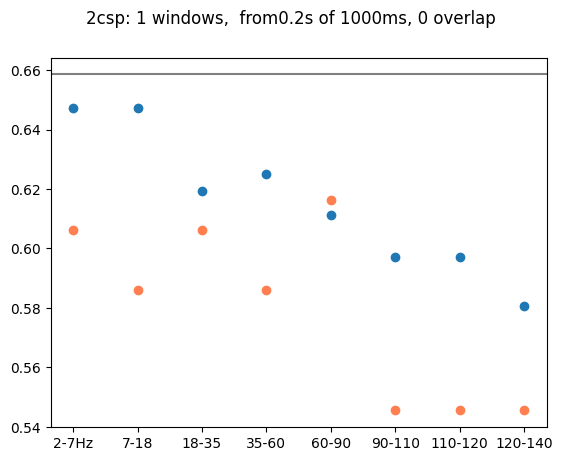

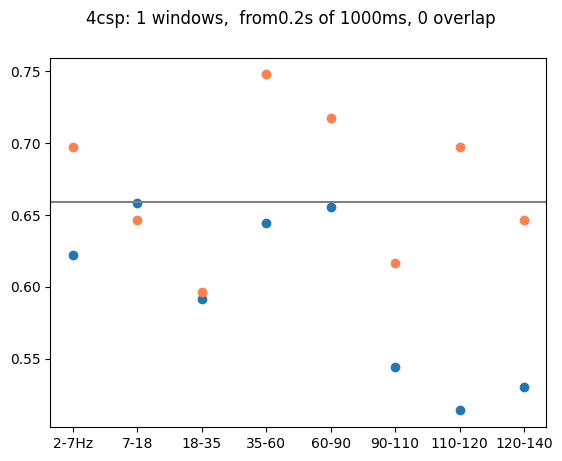

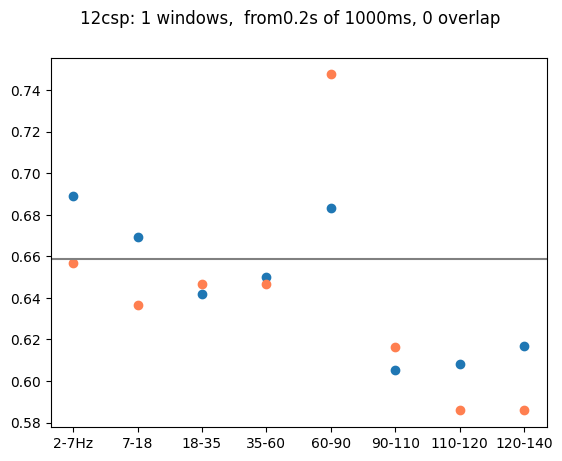

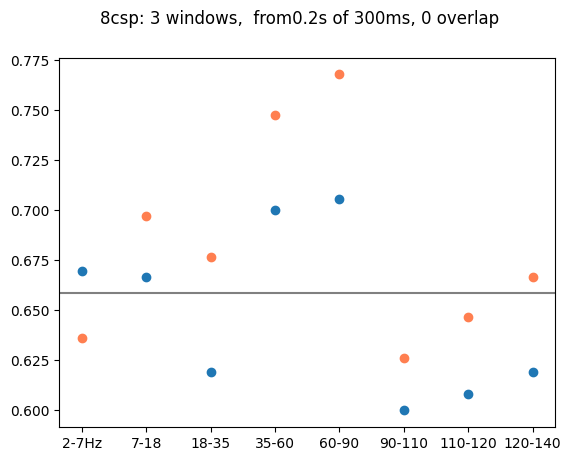

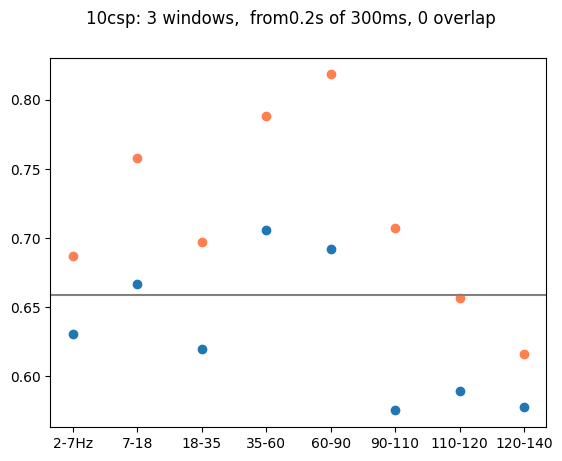

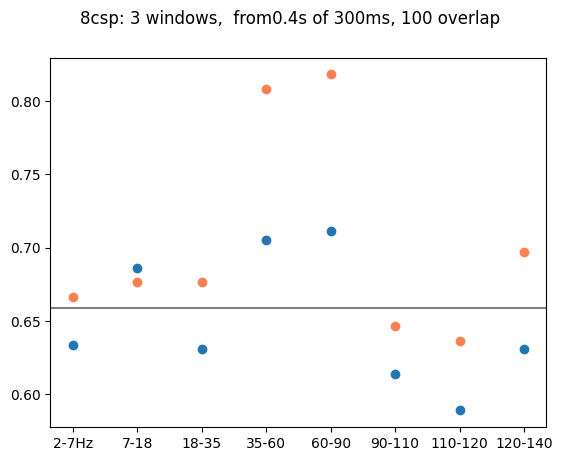

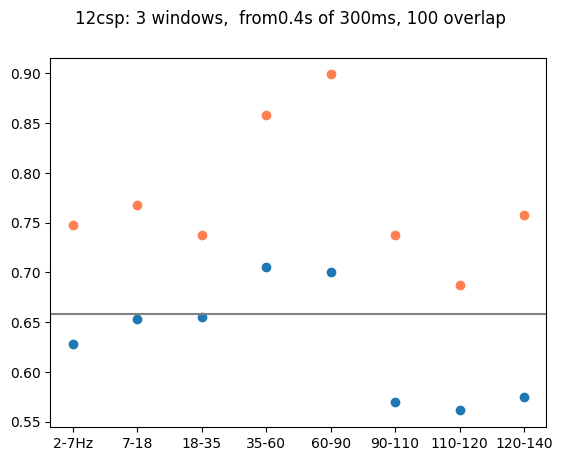

In [10]:
find_best_accuracy()

left vs rest 

In [11]:
conditions = ['left','right']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset

Number of events,50
Events,left: 27right: 23
Time range,-2.000 – 7.999 sec
Baseline,off


In [13]:
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
full_chance = np.mean(y == y[0])
full_chance = max(full_chance, 1. - full_chance)

running config 1 .
[0.48       0.44666667 0.38222222 0.40666667 0.40444444 0.41555556
 0.41555556 0.39777778]
[0.42735043 0.4957265  0.41880342 0.41025641 0.44444444 0.43589744
 0.41880342 0.45299145]
[0.45555556 0.45333333 0.41555556 0.41777778 0.44888889 0.49333333
 0.47111111 0.46      ]
[0.47863248 0.45299145 0.4017094  0.47008547 0.48717949 0.53846154
 0.46153846 0.4957265 ]
running config 2 ..
running config 3 ...
running config 4 ....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

running config 5 .....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

[0.45333333 0.48       0.45333333 0.46888889 0.48       0.49111111
 0.48666667 0.47111111]
[0.56410256 0.39316239 0.47008547 0.41025641 0.52991453 0.58119658
 0.52991453 0.4957265 ]


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

running config 6 ......


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6876\3714965853.

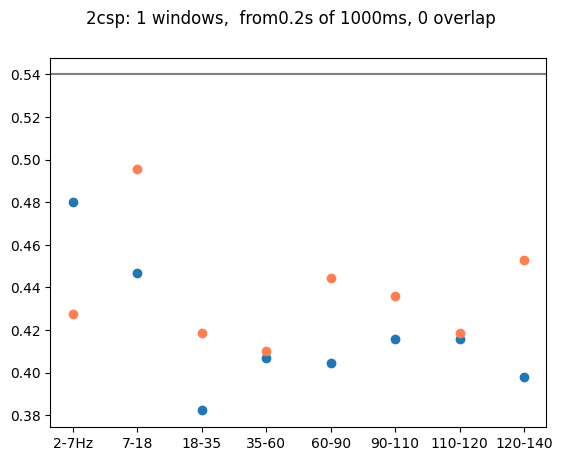

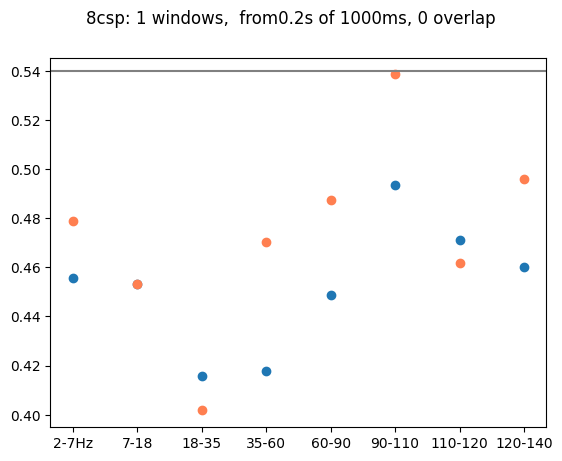

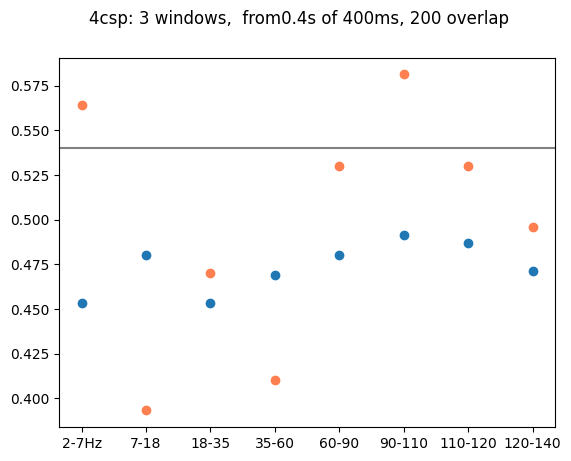

In [14]:
find_best_accuracy()

In [9]:
def find_best_accuracy():
    optimal_config = [0,0,0,0,0]
    max_accuracy = 0
    cnf_i = 0
    best_score = 0
    best_val_score = 0
    best_config = [0,0,0]
    for cnf in time_config:
        print('running config',cnf_i+1,'.'*(cnf_i+1))
        n_windows, t_min, width, overlap = cnf
        component_score = []
        cmp_i = 0
        for cmp in components:
            csp = CSP(n_components=cmp, reg=None, log=True, norm_trace=False, rank='info')

            test_rep_train_score = []
            test_rep_test_score = []
            for test_rep in range(9) :
                #split training set
                train_epochs, test_epochs, y_train, y_test = train_test_split(subset, y)
                train_epochs = concatenate_epochs(train_epochs)
                test_epochs = concatenate_epochs(test_epochs)
                chance = np.mean(y_train == y_train[0])
                chance = max(chance, 1. - chance)

                freq_scores_mean = []
                for freq, (fmin, fmax) in enumerate(freq_ranges):
                    X = []
                    train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()

                    cv_score = []
                    for val_rep in range(5):
                        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + val_rep)
                        cv_split = cv.split(train_data)
                        single_scr = []
                        for train_idx, test_idx in cv_split:
                                y_train_train, y_test_train = y_train[train_idx], y_train[test_idx]
                                X_train = []
                                X_test = []
                                csp.fit(train_data[train_idx], y_train_train)
                                w_min = 0
                                for i in range(n_windows):
                                    w_max = w_min + width
                                    X_train.append(csp.transform(train_data[train_idx,:,w_min:w_max]))
                                    X_test.append(csp.transform(train_data[test_idx,:,w_min:w_max]))
                                    w_min += w_max - overlap

                                X_train = np.concatenate(np.array(X_train), axis=1)
                                X_test = np.concatenate(np.array(X_test), axis=1)
                                if X_train.shape[1] > 7:
                                    X_train = pca.fit_transform(X_train)
                                    X_test = pca.transform(X_test)

                                lda.fit(X_train, y_train_train)
                                single_scr.append(lda.score(X_test, y_test_train))
                        cv_score.append(np.median(single_scr))

                    freq_scores_mean.append(np.mean(cv_score))

                val_scores = validate_config(
                    train_epochs, test_epochs, y_train, y_test, cnf, cmp, freq_scores_mean)
                
                test_rep_test_score.append(val_scores)    
                test_rep_train_score.append(freq_scores_mean)
                
            optimal_config = [cnf_i,cmp,freq]
            
            test_rep_train_score = np.mean(test_rep_train_score, axis=0)
            test_rep_test_score = np.mean(test_rep_test_score, axis=0)
            
            max_train_test_score = np.max(np.mean([test_rep_train_score, test_rep_test_score], axis=0))
            
            if max_train_test_score > best_score : 
                print(test_rep_train_score)
                print(test_rep_test_score)
                csp_fig, axes = plt.subplots(1)
                axes.scatter(freq_tags, test_rep_train_score)
                axes.scatter(freq_tags, test_rep_test_score, color='coral')
                csp_fig.suptitle('{}csp: {} windows,  from{}s of {}ms, {} overlap'.format(optimal_config[1],n_windows,t_min,width,overlap))
                axes.axhline(full_chance, c='grey')
               
                best_score = max_train_test_score
        
            cmp_i += 1    
        cnf_i += 1
        
def validate_config(train_epochs, test_epochs, y_train, y_test, config, csp, train_scores):
    n_windows, t_min, width, overlap = config
    csp = CSP(n_components=csp, reg=None, log=True, norm_trace=False, rank='info')
    freq_score = []
    validated = False
    for freq, (fmin, fmax) in enumerate(freq_ranges):
        X_train = []
        X_test = []
        train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
        test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
        
        csp.fit(train_data, y_train)
        w_min = 0
        for i in range(n_windows):
            w_max = w_min + width
            X_train.append(csp.transform(train_data[:,:,w_min:w_max]))
            X_test.append(csp.transform(test_data[:,:,w_min:w_max]))
            w_min += w_max - overlap

        X_train = np.concatenate(np.array(X_train), axis=1)
        X_test = np.concatenate(np.array(X_test), axis=1)
        
        if X_train.shape[1] > 7:
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            
        lda.fit(X_train, y_train)
        freq_score.append(lda.score(X_test, y_test))
    
    return freq_score
    